In [61]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib
import matplotlib.pyplot as plt
from sklearn.covariance import EllipticEnvelope
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import LabelEncoder

import warnings
warnings.filterwarnings("ignore")

In [62]:
data = pd.read_csv("data/dataset.csv")
data.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237


We define anomaly detectors

In [63]:
classifiers = {
    'Elliptic Envelope': EllipticEnvelope(contamination=0.25),
    'Isolation Forest' : IsolationForest(n_estimators=100, contamination=0.15),
    'OCSVM'            : OneClassSVM(nu=0.15, kernel="rbf", gamma=0.3),
}

# Visualization

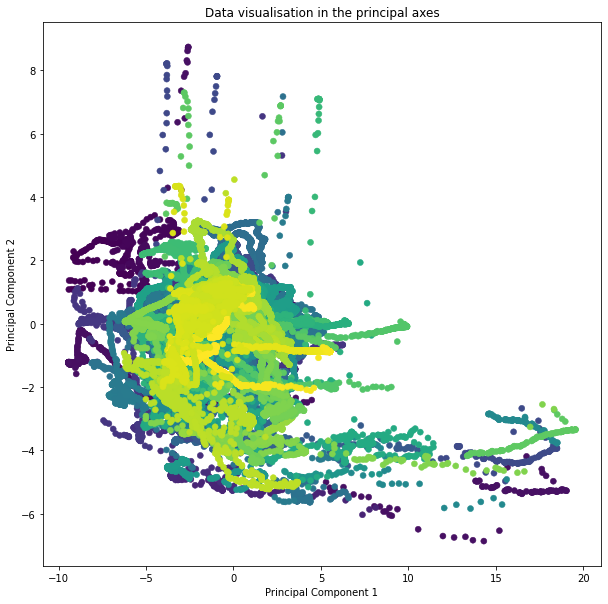

In [64]:
def do_pca(data,nb):
    pca = PCA(n_components=nb)
    results = pca.fit_transform(data)
    return results

def plot_pca(data_pca,title,pred=None) :
    labels = LabelEncoder().fit_transform(data['day_cycle_window'])
    plt.figure(figsize=(10,10))
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")

    if pred is not None :
        plt.scatter(data_pca[:,0],data_pca[:,1], s=4, lw=0)
        # Plot circles around the predicted outliers
        plt.scatter(data_pca[pred==-1, 0], data_pca[pred==-1, 1], 
           lw=2, facecolors="none", edgecolors="r", s=80, label="predicted outlier")
    else :
        plt.scatter(data_pca[:,0],data_pca[:,1], c=labels, linewidths= 0.5)
    plt.title(title)
    plt.show()

pca = PCA(n_components=2)
data_pca = pca.fit_transform(data.drop('day_cycle_window',axis=1))

plot_pca(data_pca,"Data visualisation in the principal axes")

In [65]:
explainability = pca.explained_variance_ratio_

print('Explainability of 2 principal components : ', np.sum(explainability))

Explainability of 2 principal components :  0.7429794014310778


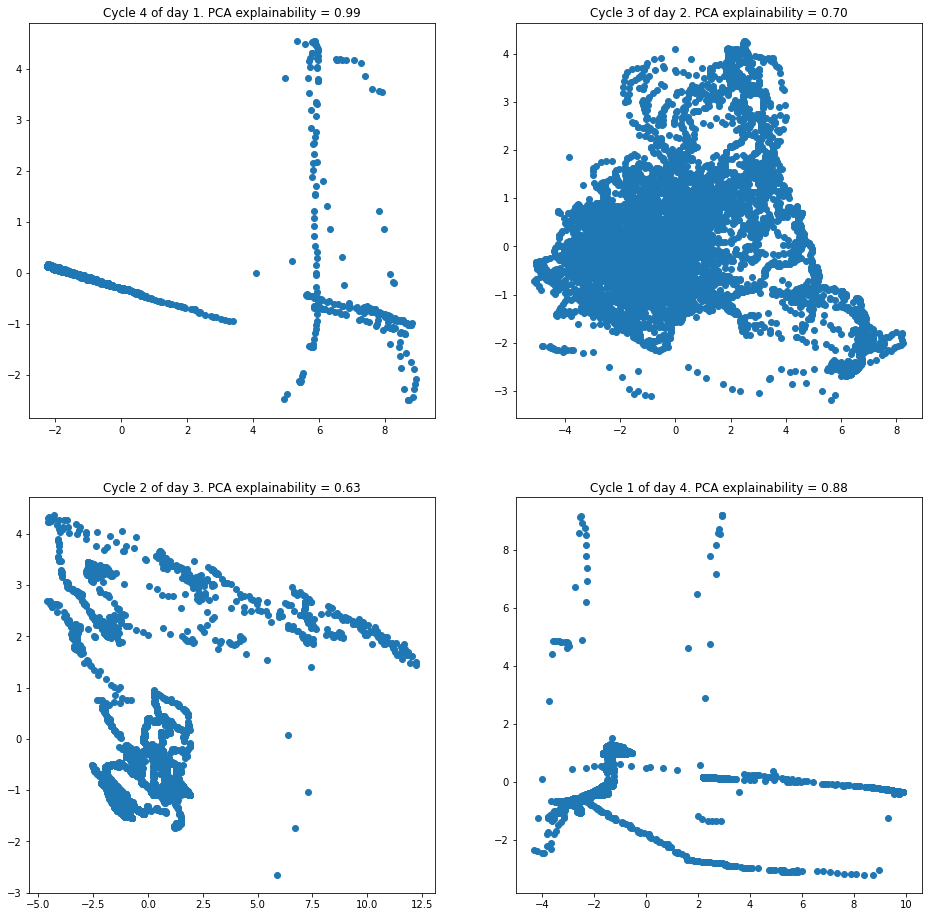

In [66]:
## Vizualisation for a given set of cycles 

data_splitted = data.copy()
data_splitted[['day','cycle','window']] = data_splitted['day_cycle_window'].str.split(pat="_",expand=True)

_, axes = plt.subplots(2, 2, figsize = (16,16))

pca = PCA(n_components=2)

for i in range(4):
    day = i+1
    cycle = 5 - (i+1)

    data_pca = data_splitted[data_splitted['day'] == str(day)]
    data_pca = data_pca[data_pca['cycle'] == str(cycle)]

    data_pca = data_pca.drop('day_cycle_window',axis=1)
    data_pca = data_pca.drop('day',axis=1)
    data_pca = data_pca.drop('cycle',axis=1)
    data_pca = data_pca.drop('window',axis=1)

    res = pca.fit_transform(data_pca)

    PCA_score = np.sum(pca.explained_variance_ratio_)

    axes[i//2, i%2].plot(res[:,0], res[:,1], 'o')
    axes[i//2, i%2].set_title('Cycle ' + str(5-i-1) + ' of day ' + str(i+1) + '. PCA explainability = %0.2f' % PCA_score)



Remarques intéressantes : c'est très variable d'un cycle à l'autre, ça vaut la peine de s'intéresser à cette échelle à priori + PCA plus ou moins représentative.

In [67]:
from scipy.signal import find_peaks

def num_peaks(seq):
    '''Function that calculates the number of peaks in a series'''
    return len(find_peaks(seq)[0])

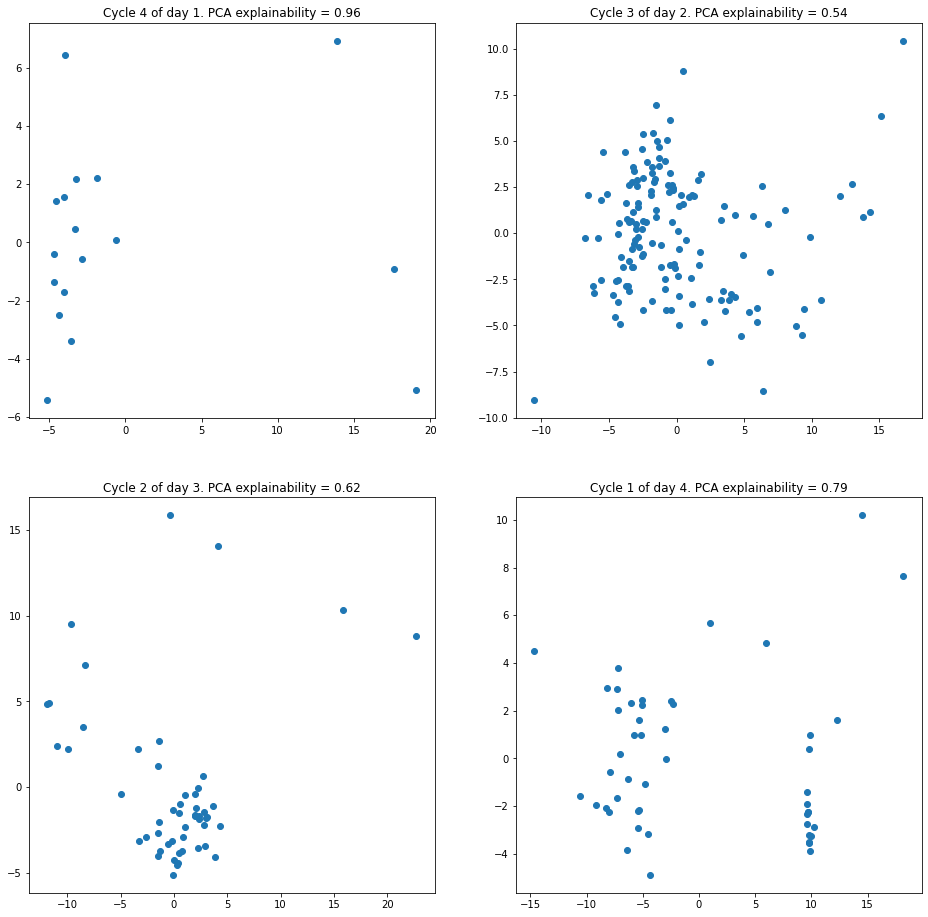

In [68]:
## Vizualisation for a given set of cycles and 1 point for 1 window

data_splitted = data.copy()
data_splitted[['day','cycle','window']] = data_splitted['day_cycle_window'].str.split(pat="_",expand=True)

_, axes = plt.subplots(2, 2, figsize = (16,16))

pca = PCA(n_components=2)

for i in range(4):
    day = i+1
    cycle = 5 - (i+1)

    data_pca = data_splitted[data_splitted['day'] == str(day)]
    data_pca = data_pca[data_pca['cycle'] == str(cycle)]

    data_pca = data_pca.groupby(['window']).agg(['median','mean','std','max','min',num_peaks])


    data_pca = data_pca.drop('day_cycle_window',axis=1)
    data_pca = data_pca.drop('day',axis=1)
    data_pca = data_pca.drop('cycle',axis=1)

    res = pca.fit_transform(data_pca)

    PCA_score = np.sum(pca.explained_variance_ratio_)

    axes[i//2, i%2].plot(res[:,0], res[:,1], 'o')
    axes[i//2, i%2].set_title('Cycle ' + str(5-i-1) + ' of day ' + str(i+1) + '. PCA explainability = %0.2f' % PCA_score)

Remarques intéressantes : même remarque ie c'est très variable d'un cycle à l'autre, ça vaut la peine de s'intéresser à cette échelle à priori + PCA plus ou moins représentative.

# 1. Naive approach
We know how to classify a point as an anomaly or not. However, a window is a set of 100 points. The first idea is to reduce those 100 points into one point using statiscs. We first calculate the mean of each window.

In [69]:
data_reduced = data.groupby(['day_cycle_window']).mean()

data_reduced.head()

,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
day_cycle_window,,,,,,,,,,,
1_1_1,-1.926141,-2.456284,-2.487394,-2.481230,-2.388674,-1.984092,-2.447148,-1.169837,2.848242,-1.370045,-2.500060
1_1_10,1.204735,1.123558,1.077596,1.128253,1.136183,1.228688,1.199106,1.308412,-0.429810,-0.088168,1.016565
1_1_11,0.742475,0.703459,0.680578,0.740626,0.768269,0.736631,0.755362,0.783155,-0.429810,-0.091129,0.669938
1_1_12,0.300162,0.289058,0.289114,0.342999,0.396993,0.254292,0.324268,0.264819,-0.429810,-0.085217,0.303699
1_1_13,0.140935,0.152487,0.161874,0.200016,0.226986,0.083547,0.170042,0.068720,-0.429810,-0.089727,0.186059


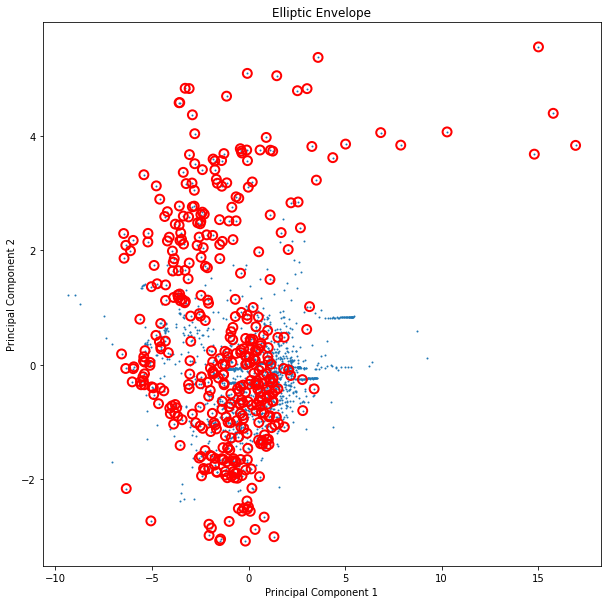

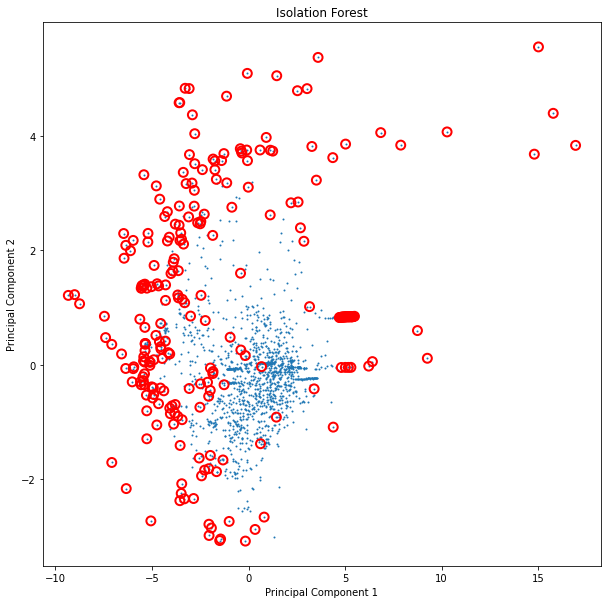

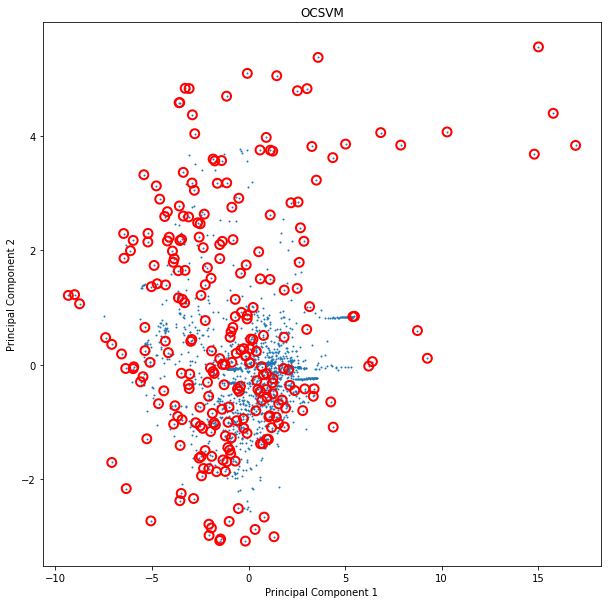

In [70]:
data_reduced_pca = do_pca(data_reduced,2)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,pred=pred)


# 2. A better alternative for the naive approach
Instead of computing the mean, we can extract many other useful characteristics from each window whose points form a sequence or a `time series`. 
We can use the library `tsfresh` to calculate time series features, however we will only use the `mean`, `median`, `maximum`, `minimum`, `standard deviation` and the `number of peaks`. 

In [71]:
from scipy.signal import find_peaks

def num_peaks(seq):
    '''Function that calculates the number of peaks in a series'''
    return len(find_peaks(seq)[0])

In [72]:
data_reduced = data.groupby(['day_cycle_window']).agg(['median','mean','std','max','min',num_peaks])

data_reduced.head()

p1                                                    \
                    median      mean       std       max       min num_peaks   
day_cycle_window                                                               
1_1_1            -1.849016 -1.926141  0.591155 -0.805191 -3.107670         2   
1_1_10            1.118294  1.204735  0.245958  1.582127  0.900633         1   
1_1_11            0.800962  0.742475  0.133627  0.900633  0.486868         0   
1_1_12            0.290764  0.300162  0.089126  0.486868  0.169069         0   
1_1_13            0.137776  0.140935  0.006691  0.161408  0.137776         0   

                        p2                                ...       p10  \
                    median      mean       std       max  ...       std   
day_cycle_window                                          ...             
1_1_1            -2.565392 -2.456284  0.739638 -1.112276  ...  0.673869   
1_1_10            1.037859  1.123558  0.242592  1.528097  ...  0.007340   
1_1_11            0.751052  0.703459  0.132878  0.855591  ...  0.007835   
1_1_12            0.280503  0.289058  0.077160  0.441402  ...  0.008146   
1_1_13            0.150402  0.152487  0.004849  0.167603  ...  0.008337   

                                                     p11                      \
                       max       min num_peaks    median      mean       std   
day_cycle_window                                                               
1_1_1             0.495528 -2.283434        10 -2.857906 -2.500060  0.724468   
1_1_10           -0.070064 -0.107307        19  0.916551  1.016565  0.211292   
1_1_11           -0.075944 -0.106327        11  0.722549  0.669938  0.121043   
1_1_12           -0.068104 -0.101053         9  0.293052  0.303699  0.068842   
1_1_13           -0.070064 -0.103387        10  0.182155  0.186059  0.005184   

                                                
                       max       min num_peaks  
day_cycle_window                                
1_1_1            -1.244472 -3.183571         2  
1_1_10            1.437874  0.807778         1  
1_1_11            0.807778  0.450576         0  
1_1_12            0.450576  0.208743         0  
1_1_13            0.197741  0.179901         2  

[5 rows x 66 columns]

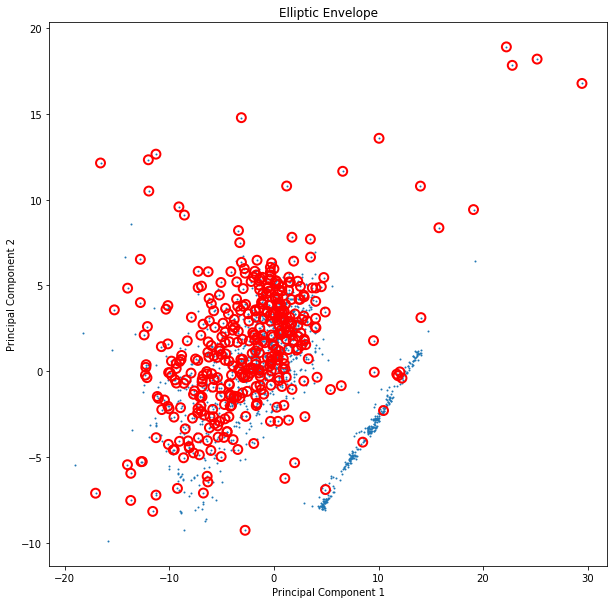

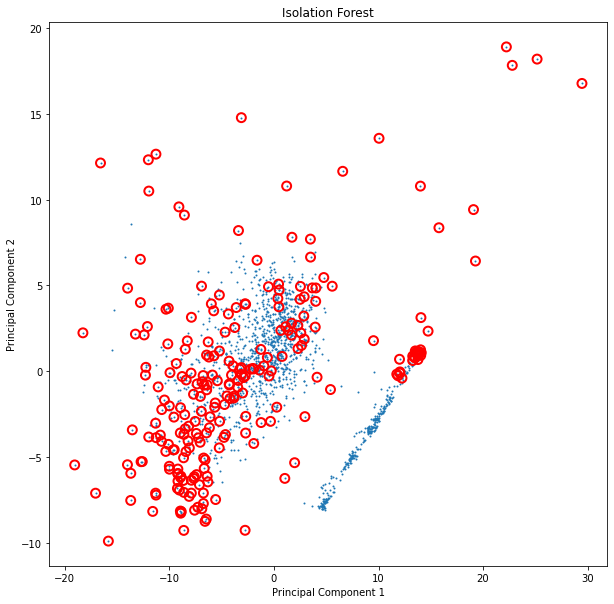

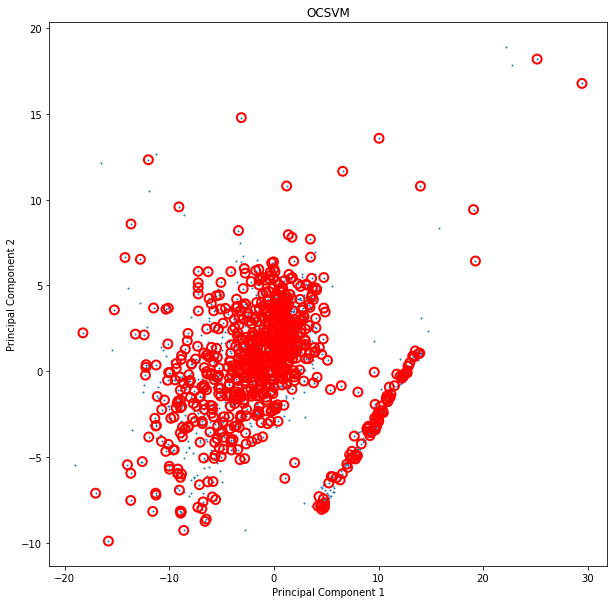

In [73]:
data_reduced_pca = do_pca(data_reduced,2)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,pred=pred)

# 3. Anomaly detection in each day 

In [74]:
data_reduced = data_reduced.reset_index()
data_reduced[['day','cycle','window']] = data_reduced['day_cycle_window'].str.split(pat="_",expand=True)

day :  1


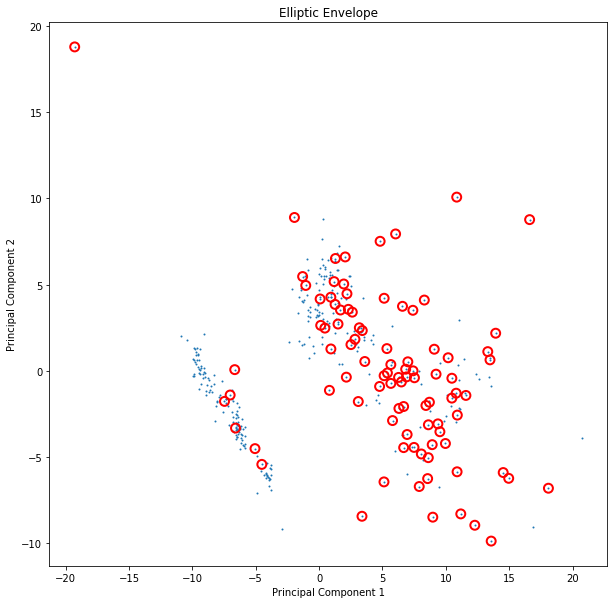

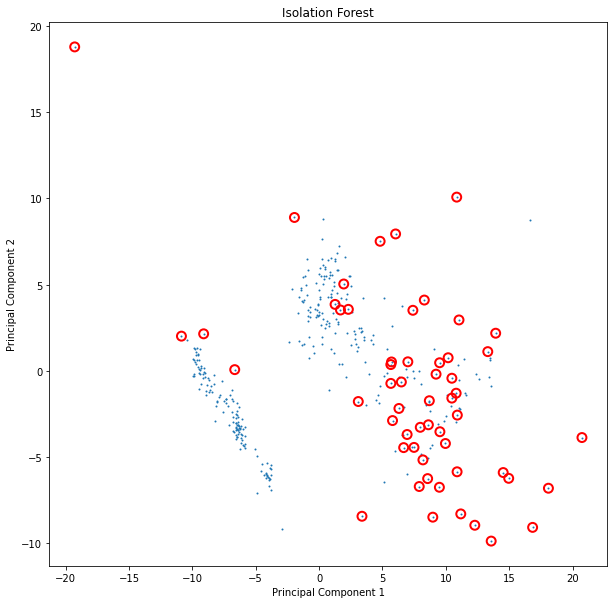

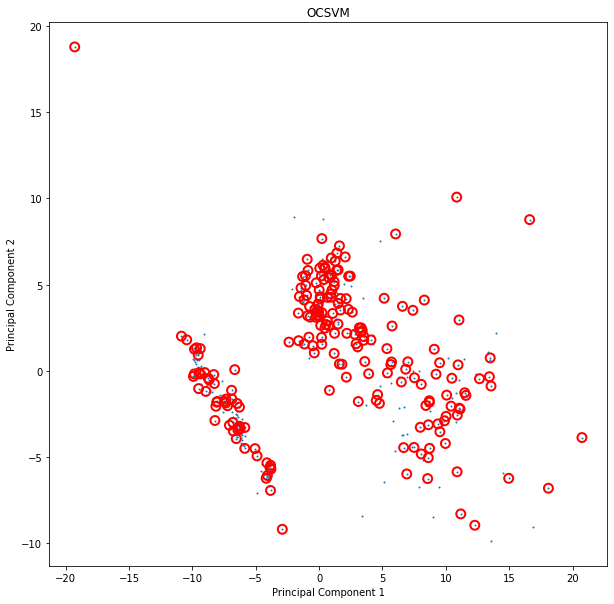

day :  2


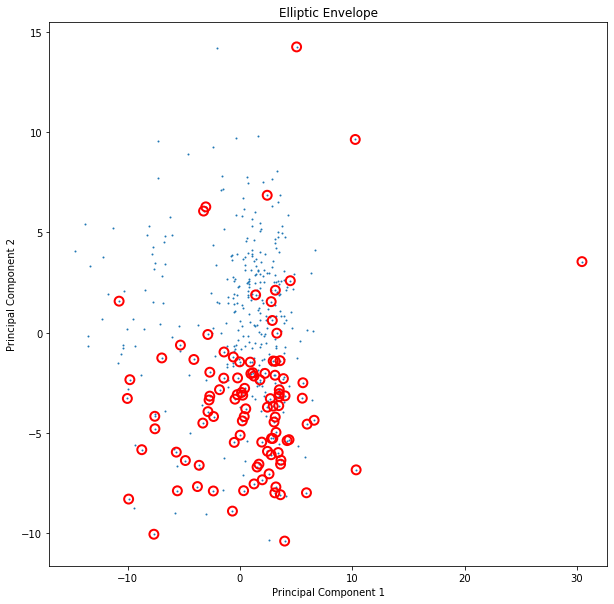

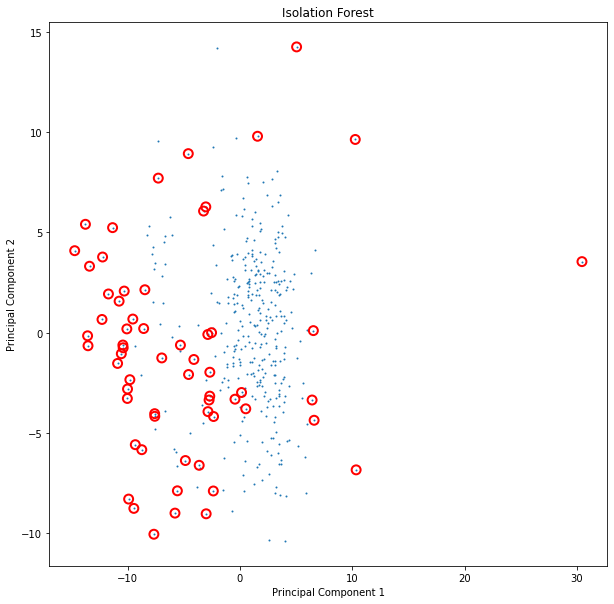

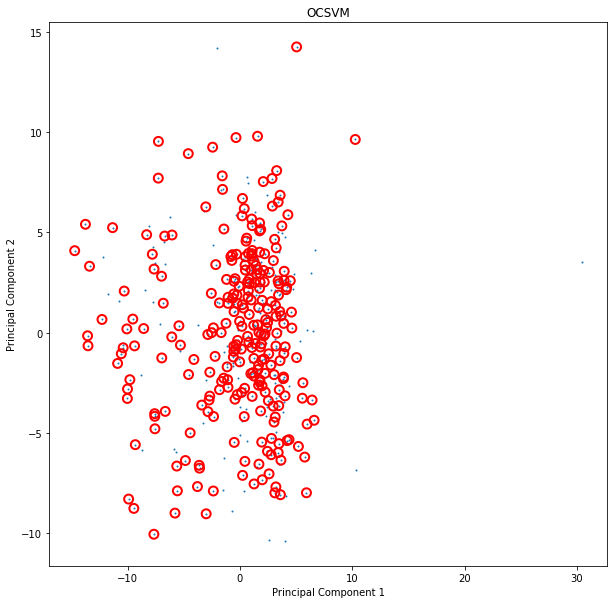

day :  3


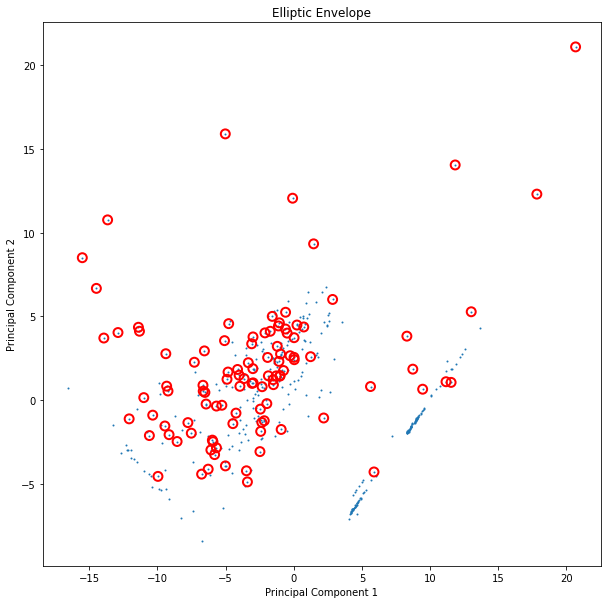

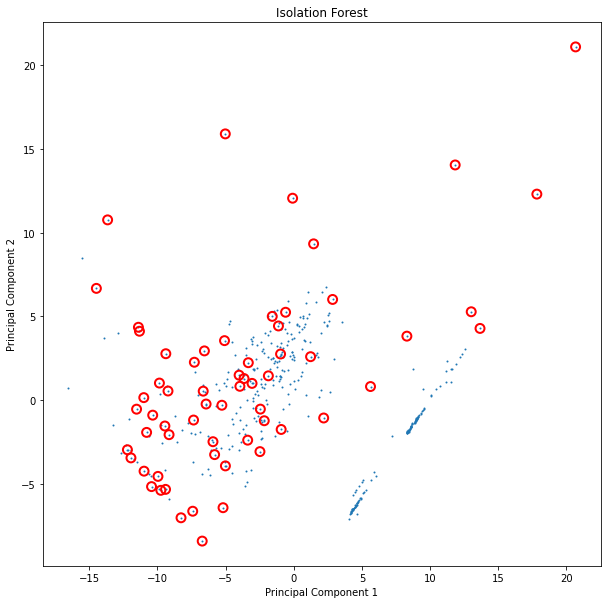

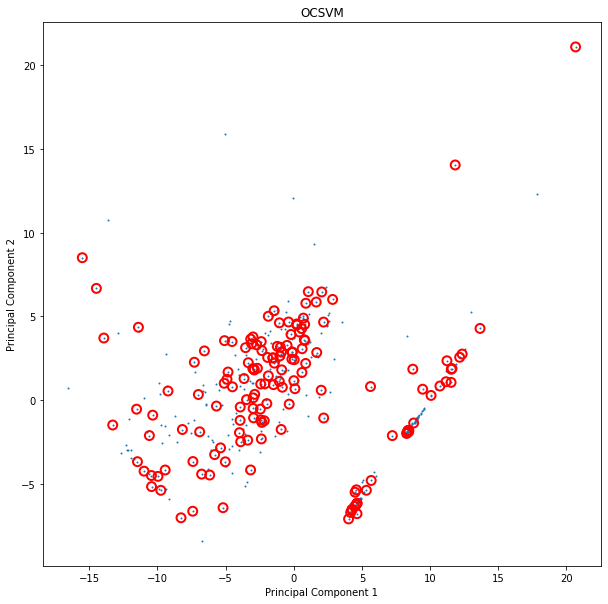

day :  4


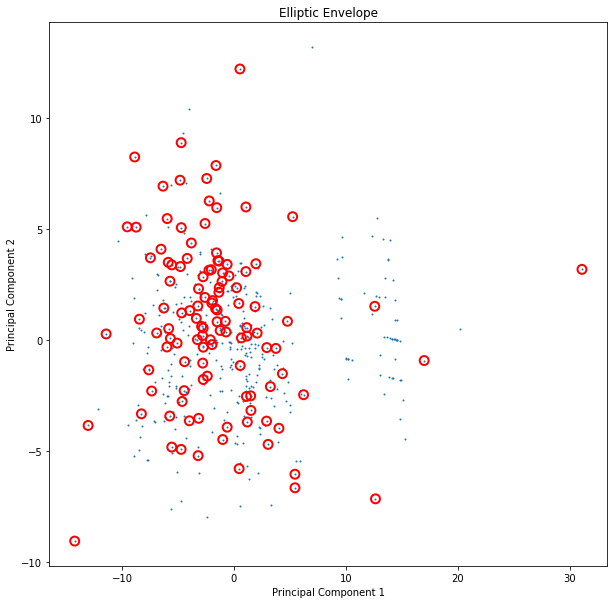

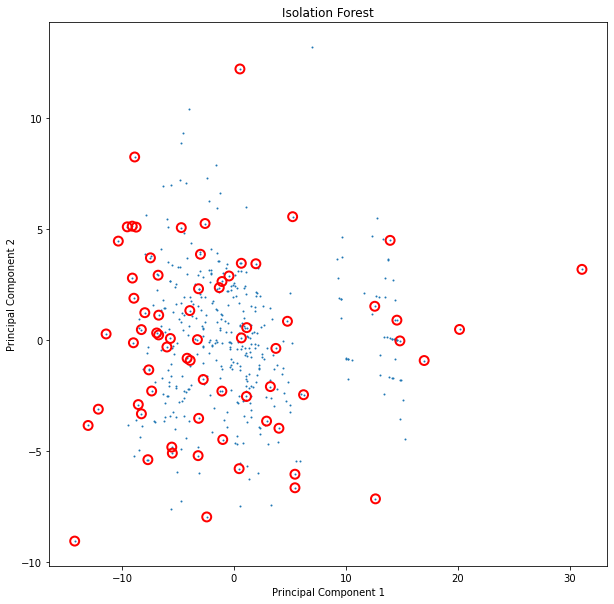

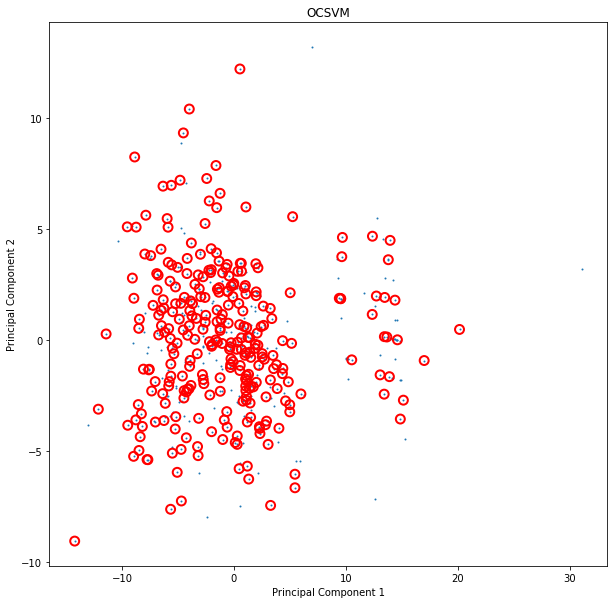

In [75]:
for day,df in data_reduced.groupby(['day']):
    df2 = df.drop(columns=['day','cycle','window','day_cycle_window'])
    print("day : ",day)
    df_pca = do_pca(df2,2)

    # Learn a frontier for outlier detection with several classifiers
    xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        clf.fit(df2)
        pred = clf.predict(df2)
        plot_pca(df_pca,clf_name,pred=pred)
    

In [76]:
data_reduced.reset_index()['day_cycle_window'].str.split(pat="_",expand=True)

,0,1,2
0,1,1,1
1,1,1,10
2,1,1,11
3,1,1,12
4,1,1,13
...,...,...,...
1632,4,4,95
1633,4,4,96
1634,4,4,97
1635,4,4,98


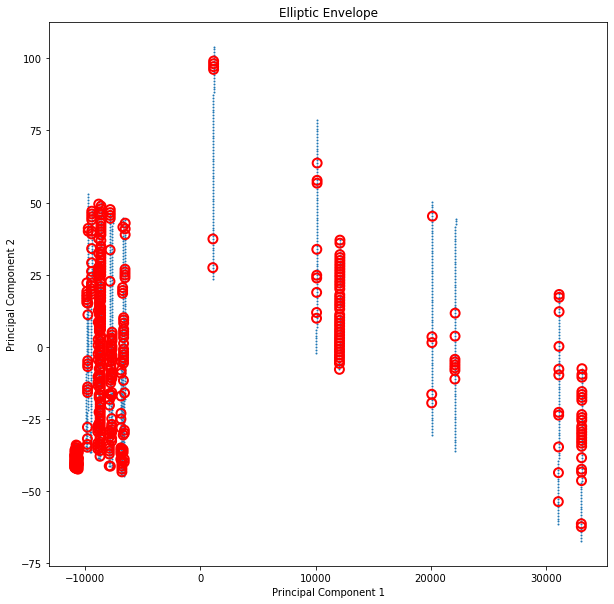

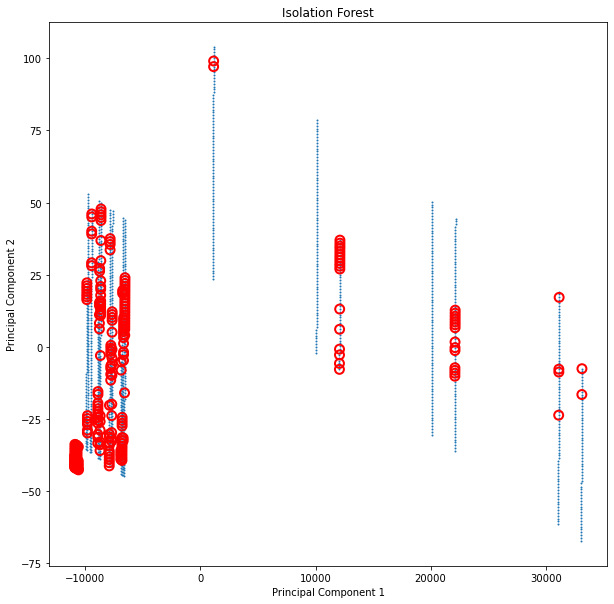

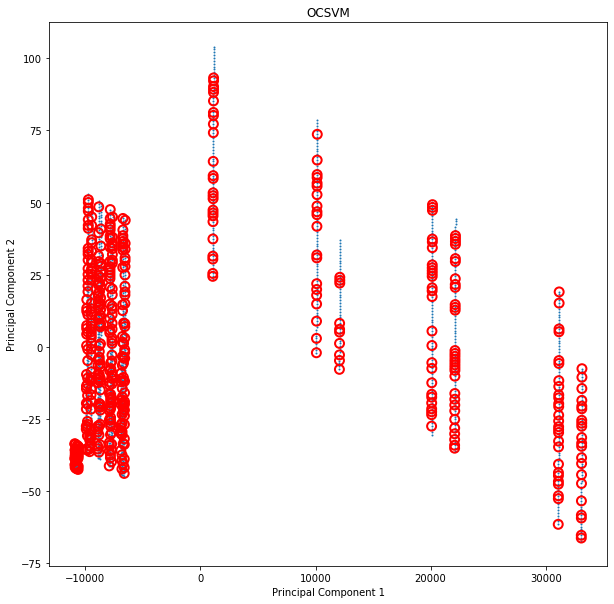

In [77]:
data_reduced_pca = do_pca(data_reduced,2)

# Learn a frontier for outlier detection with several classifiers
xx1, yy1 = np.meshgrid(np.linspace(0, 6, 500), np.linspace(1, 4.5, 500))
for i, (clf_name, clf) in enumerate(classifiers.items()):
    clf.fit(data_reduced)
    pred = clf.predict(data_reduced)
    plot_pca(data_reduced_pca,clf_name,pred=pred)

# 4. Anomaly detection in each cycle

In [87]:
data_reduced = data.copy()
data_reduced[['day','cycle','window']] = data_reduced['day_cycle_window'].str.split(pat="_",expand=True)

# data_reduced = data_reduced.drop(columns=['day', 'cycle','day_cycle_window'])
# data_reduced = data_reduced.groupby(['window']).agg(['median','mean','std','max','min',num_peaks])


data_reduced.head()

,day_cycle_window,p1,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11,day,cycle,window
0,1_1_1,-0.805191,-1.141993,-1.328327,-1.516693,-1.373962,-0.80827,-1.070547,-0.504352,2.807146,0.495528,-1.246737,1,1,1
1,1_1_1,-0.805191,-1.134902,-1.320393,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.894177,0.494467,-1.244472,1,1,1
2,1_1_1,-0.805191,-1.117304,-1.307167,-1.505848,-1.361560,-0.80784,-1.064212,-0.516000,2.981904,0.429370,-1.244472,1,1,1
3,1_1_1,-0.814231,-1.114206,-1.287593,-1.442302,-1.287565,-0.80784,-1.045557,-0.516000,3.063298,0.348056,-1.244472,1,1,1
4,1_1_1,-0.848104,-1.112276,-1.285393,-1.429076,-1.270722,-0.80784,-1.017575,-0.664906,3.049237,0.118828,-1.270237,1,1,1


In [100]:
L_anomalies = [[[] for _ in range(4)] for _ in range(len(classifiers.items()))]

pca = PCA(n_components=2)

## 240 sec to run 
for (day, cycle), df in data_reduced.groupby(['day', 'cycle']):
    df2 = df.groupby(['window']).agg(['median', 'mean', 'std', 'max', 'min', num_peaks])
    df2 = df.drop(columns = ['day', 'cycle', 'day_cycle_window'])

    df_pca = pca.fit_transform(df2)
    PCA_score = np.sum(pca.explained_variance_ratio_)

    print('Day ' + day + ', cycle ' + cycle)

    # Learn a frontier for outlier detection with several classifiers
    for i, (clf_name, clf) in enumerate(classifiers.items()):
        df_predict = clf.fit_predict(df2)
        L_anomalies[i][int(day)-1].append(np.sum(df_predict == -1))

Day 1, cycle 1
[[[1694], [], [], []], [[], [], [], []], [[], [], [], []]]
[[[1694], [], [], []], [[1017], [], [], []], [[], [], [], []]]
[[[1694], [], [], []], [[1017], [], [], []], [[1133], [], [], []]]
Day 1, cycle 2
[[[1694, 4501], [], [], []], [[1017], [], [], []], [[1133], [], [], []]]
[[[1694, 4501], [], [], []], [[1017, 2701], [], [], []], [[1133], [], [], []]]
[[[1694, 4501], [], [], []], [[1017, 2701], [], [], []], [[1133, 2703], [], [], []]]
Day 1, cycle 3
[[[1694, 4501, 139], [], [], []], [[1017, 2701], [], [], []], [[1133, 2703], [], [], []]]
[[[1694, 4501, 139], [], [], []], [[1017, 2701, 83], [], [], []], [[1133, 2703], [], [], []]]
[[[1694, 4501, 139], [], [], []], [[1017, 2701, 83], [], [], []], [[1133, 2703, 87], [], [], []]]
Day 1, cycle 4
[[[1694, 4501, 139, 414], [], [], []], [[1017, 2701, 83], [], [], []], [[1133, 2703, 87], [], [], []]]
[[[1694, 4501, 139, 414], [], [], []], [[1017, 2701, 83, 248], [], [], []], [[1133, 2703, 87], [], [], []]]
[[[1694, 4501, 139, 4

[[[1694, 4501, 139, 414, 2330], [4501, 1891, 3608], [4501, 1278, 4502], [1221, 4501, 1606, 3994]], [[1017, 2701, 83, 248, 1393], [2701, 1132, 2165], [2701, 768, 2701], [730, 2698, 964, 2397]], [[1133, 2703, 87, 259, 1428], [2705, 1150, 2163], [2711, 768, 2846], [737, 2762, 964, 2521]]]


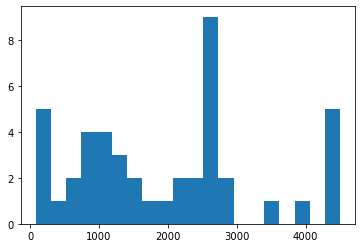

In [117]:
print(L_anomalies)

L_anomalies_flattend = [item for subsublist in L_anomalies for sublist in subsublist for item in sublist]
plt.hist(L_anomalies_flattend, bins = 20);

In [122]:
## Vizualisation of cycles where number of anomalies is greater than 3000 

ind = []

for i in range(len(L_anomalies)):
    for j in range(len(L_anomalies[i])):
        for k in range(len(L_anomalies[i][j])):

            if L_anomalies[i][j][k] > 3000 : # jour i+1 méthode j+1 cycle k+1
                ind.append((i,j,k))

print(ind)


# comparer les windows au sein des cycles avec un nombre d'anomalies élevé 
...



[(0, 0, 1), (0, 1, 0), (0, 1, 2), (0, 2, 0), (0, 2, 2), (0, 3, 1), (0, 3, 3)]


Ellipsis